# Step1 - Scrapping

In [5]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scrapy # we will use the scrapy package
import requests
from scrapy.selector import Selector

# Set seaborn display
sns.set()

### Training: scrapping the Polytechnique website

Using selectors, we created a spider which get all the information from polytechnique News page.

#### Running spider 

(Running the spider might take over one minute if you remove the __"-a nb_article_max=100"__ to get all the articles)

In [7]:
# Parameters for spider execution
file_path = '../scrapped_data/'
file_name = 'actuX_basic_nbk_data.jl'
spider_name = 'actuX_basic'
path = file_path + file_name

# Check if file already exists
if file_name in os.listdir(file_path):
    _ = os.remove(path)

# Execution of spider
cmd1 = 'cd ../TA_scrapy/'
cmd2 = 'scrapy crawl {} -o {} -a nb_article_max=100'.format(spider_name, path)
cmd = cmd1 + ' && ' + cmd2
_ = os.system(cmd)

if _==0:
    print("Scrapping finished.")
else:
    print('Look at the bash to understand error.')

Scrapping finished.


#### Reading scrapped data

In [8]:
# Function rto read jl file
def read_jl_file(file_name):
    values = []
    with open(file_name, 'rb') as f:
        line = '---'
        while len(line)>1:
            line = f.readline()
            values.append(line)
    values = values[:-1]
    values = [json.loads(i) for i in values]
    df = pd.DataFrame(values)
    return df

# Reading file
df = read_jl_file(path)

In [9]:
# Having a brief look at data
print(df.shape)

df.head()

(100, 6)


,content,date_article,lien_article,related_subject,related_subject_links,titre_article
0,L’École polytechnique est le 1er établissement...,30 Janvier 2020,/fr/content/lx-la-plus-internationale-des-univ...,[Classement],[/fr/classement],"L’X, la plus internationale des universités fr..."
1,Les priorités de l’X pour 2020 s’inscrivent da...,28 Janvier 2020,/fr/content/lecole-polytechnique-fixe-ses-prio...,"[Institutionnel, Campus]","[/fr/type/institutionnel, /fr/type/campus]",L’École polytechnique fixe ses priorités pour ...
2,"Le 14 février 2020, l’X célèbre les 35 ans de ...",28 Janvier 2020,/fr/content/lamplification-laser-35-ans-apres-...,"[Recherche, Conference]","[/fr/les-actualites-de-la-recherche, /fr/confe...","L’amplification laser : 35 ans après, des pote..."
3,Deux équipes de trois élèves de l’X sont arriv...,27 Janvier 2020,/fr/content/lx-remporte-pour-la-premiere-fois-...,"[Campus, Prix]","[/fr/type/campus, /fr/prix-et-distinctions]",L’X remporte pour la première fois le concours...
4,Le Département d’économie et la chaire Econoph...,27 Janvier 2020,/fr/content/colloque-la-multidisciplinarite-po...,"[Recherche, Conference, CREST, LADHYX]","[/fr/les-actualites-de-la-recherche, /fr/confe...",Colloque : la multidisciplinarité pour mieux c...


#### Brief analysis of scrapped data

__Seeing the most frequent mentions__

In [10]:
related_subjects = []
for subjects in df['related_subject'].tolist():
    related_subjects += subjects     
pd.Series(related_subjects).value_counts().head()

Recherche          54
Formation          18
Campus             17
Prix               12
Entrepreneuriat    11
dtype: int64

__Counting the number of publications through times__

In [11]:
def translate_month(x):
    translate_dict = {
        'Janvier':'january',
        'Février':'february',
        'Mars':'march',
        'Avril':'april',
        'Mai':'may',
        'Juin':'june',
        'Juillet':'july',
        'Aout':'august',
        'Septembre':'september',
        'Octobre':'october',
        'Novembre':'november',
        'Décembre':'december'}
    for french, english in translate_dict.items():
        x = x.replace(french, english)
    return x

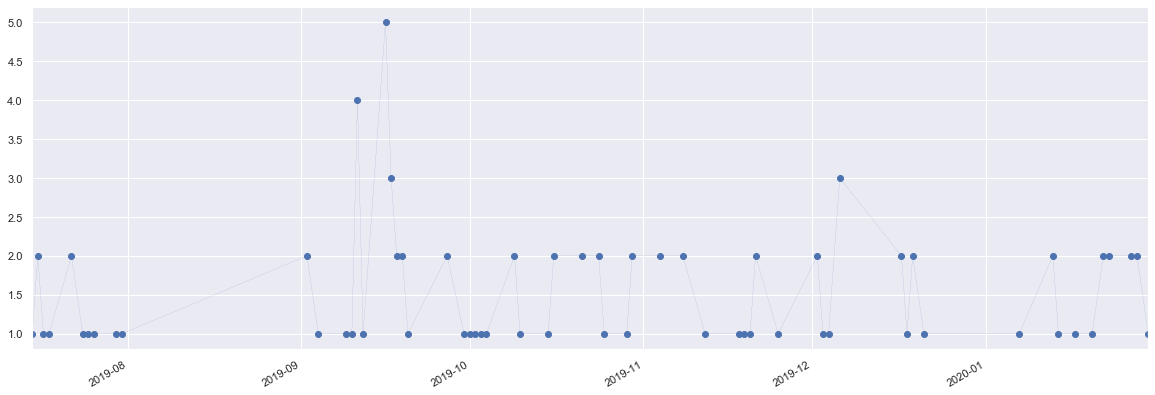

In [12]:
# Transforming French date into English date so that pandas understands it as a date
df['date'] = df['date_article'].apply(translate_month)

# Preparing for plotting
tmp = pd.to_datetime(df['date'], errors='coerce').value_counts()

# Realizing plotting
_ = plt.figure(figsize=(20,7))
_ = tmp.plot(marker='o', linewidth=0.1)
_ = plt.show()

### Project: scrapping TripAdvisor

#### Discovering TripAdvisor

Here is how we will proceed before building our spider:
- Open a review page and check how to parse it
- Open a restaurant page and check how to get reviews urls
- Open a restaurant page and check how to get to next page of reviews
- Open a city page and check how to get restaurant urls
- Open a city page and check how to get the net page of restaurants
- Try to put it altogether

In [1]:
# To begin with, 3 urls types
example_url_city = 'https://www.tripadvisor.co.uk/Restaurants-g187147-Paris_Ile_de_France.html'
example_url_restaurant = 'https://www.tripadvisor.co.uk/Restaurant_Review-g187147-d9806534-Reviews-ASPIC-Paris_Ile_de_France.html'
example_url_review = 'https://www.tripadvisor.co.uk/ShowUserReviews-g187147-d9806534-r731227577-ASPIC-Paris_Ile_de_France.html'

#### Preparing selectors in spider perspective

**Parsing restaurant list**

**Parsing restaurant page**

**Parsing review**

**Navigating between pages**